In [1]:
from google.cloud import bigquery
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import train_test_split,cross_validate
import statsmodels.api as sm

# Read and create data frames for Rent_Data

In [2]:
path = ("Source/Sell")
allFiles = glob.glob(os.path.join(path, '*.csv'))
allFiles

['Source/Sell\\Sell_data_201501-607.csv',
 'Source/Sell\\Sell_data_201608-706.csv',
 'Source/Sell\\Sell_data_201707-710.csv',
 'Source/Sell\\Sell_data_201711-802.csv']

In [3]:
np_array_list = []
cols = ['id', 'operation', 'created_on', 'property_type', 'place_name',
        'state_name', 'lat', 'lon', 'price',
        'currency', 'price_aprox_usd', 
        'surface_total_in_m2','surface_covered_in_m2']

df = pd.read_csv(allFiles[0], index_col=None, sep=',', header=0)


#Create rest of DF 
df = df[cols]
print('Parte1' + str(allFiles))
np_array_list.append(df.as_matrix())
    
    
for file_ in allFiles[1::]:
    print('Read DF ' + str(file_))
    df = pd.read_csv(file_, index_col=None, 
                     encoding= 'latin-1', header=0,)
    
    #Create rest of DF
    df = df[cols]
    np_array_list.append(df.as_matrix())
    

#Append all DF's
comb_np_array = np.vstack(np_array_list)
sell_df = pd.DataFrame(comb_np_array, columns=df.columns)

Parte1['Source/Sell\\Sell_data_201501-607.csv', 'Source/Sell\\Sell_data_201608-706.csv', 'Source/Sell\\Sell_data_201707-710.csv', 'Source/Sell\\Sell_data_201711-802.csv']


C:\Users\w10\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


Read DF Source/Sell\Sell_data_201608-706.csv


C:\Users\w10\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Read DF Source/Sell\Sell_data_201707-710.csv
Read DF Source/Sell\Sell_data_201711-802.csv


In [4]:
sell_df.shape

(2762514, 13)

# Explore & Clean data

In [5]:
sell_df.head()

,id,operation,created_on,property_type,place_name,state_name,lat,lon,price,currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2
0,9d664b1fcd42bdfcba502ef484769740b633f0b5,sell,2014-11-11,house,Atitalaquia,Hidalgo,NaN,NaN,0,NaN,0,600,NaN
1,0b695d8fb335ddda97b6162705e9e3c1f45e98ea,sell,2014-11-11,house,Monterrey,Nuevo León,NaN,NaN,0,NaN,0,90,NaN
2,73a59500b60d6ad00ad77b080e7fa4ef0dc5a7ae,sell,2014-11-11,house,Tlalpan,Distrito Federal,NaN,NaN,0,NaN,0,196,NaN
3,e95b7705e931d84918b20721560e4bf4cb874d45,sell,2014-11-11,house,Michoacán,Chiapas,NaN,NaN,0,NaN,0,448,NaN
4,4dfb43c87dfd462dfe95ef2435280607fa5425df,sell,2014-11-11,apartment,Miguel Hidalgo,Distrito Federal,19.4071,-99.2144,5.85e+07,MXN,3.71639e+06,NaN,NaN


In [6]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2762514 entries, 0 to 2762513
Data columns (total 13 columns):
id                       object
operation                object
created_on               object
property_type            object
place_name               object
state_name               object
lat                      object
lon                      object
price                    object
currency                 object
price_aprox_usd          object
surface_total_in_m2      object
surface_covered_in_m2    object
dtypes: object(13)
memory usage: 274.0+ MB


Working with dates, to get only the information since 2015

In [7]:
sell_df['created_on'] = pd.to_datetime(sell_df.created_on)

In [8]:
start_date = "2015-01-01"
end_date = sell_df['created_on'].max()

In [9]:
mask = (sell_df['created_on'] >= start_date) & (sell_df['created_on'] <= end_date)
sell_df = sell_df.loc[mask]

In [10]:
sorted(sell_df.created_on.unique())

[numpy.datetime64('2015-01-02T00:00:00.000000000'),
 numpy.datetime64('2015-01-03T00:00:00.000000000'),
 numpy.datetime64('2015-01-04T00:00:00.000000000'),
 numpy.datetime64('2015-01-05T00:00:00.000000000'),
 numpy.datetime64('2015-01-06T00:00:00.000000000'),
 numpy.datetime64('2015-01-07T00:00:00.000000000'),
 numpy.datetime64('2015-01-08T00:00:00.000000000'),
 numpy.datetime64('2015-01-09T00:00:00.000000000'),
 numpy.datetime64('2015-01-10T00:00:00.000000000'),
 numpy.datetime64('2015-01-11T00:00:00.000000000'),
 numpy.datetime64('2015-01-12T00:00:00.000000000'),
 numpy.datetime64('2015-01-13T00:00:00.000000000'),
 numpy.datetime64('2015-01-14T00:00:00.000000000'),
 numpy.datetime64('2015-01-15T00:00:00.000000000'),
 numpy.datetime64('2015-01-16T00:00:00.000000000'),
 numpy.datetime64('2015-01-17T00:00:00.000000000'),
 numpy.datetime64('2015-01-18T00:00:00.000000000'),
 numpy.datetime64('2015-01-19T00:00:00.000000000'),
 numpy.datetime64('2015-01-20T00:00:00.000000000'),
 numpy.datet

Next I have to delete all the row that contains "Null" values, this is because I neede complete information for the analysis. Also if the rent price is 0, then it represent a missing information take in consideration that you will not get your return of investment with 0 values

In [11]:
sell_df = sell_df[~sell_df['price'].isna()]
sell_df = sell_df[~sell_df['lat'].isna()]
sell_df = sell_df[~sell_df['lat'].isna()]
sell_df = sell_df[sell_df['price'] != 0]

In [12]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914707 entries, 246 to 2762513
Data columns (total 13 columns):
id                       object
operation                object
created_on               datetime64[ns]
property_type            object
place_name               object
state_name               object
lat                      object
lon                      object
price                    object
currency                 object
price_aprox_usd          object
surface_total_in_m2      object
surface_covered_in_m2    object
dtypes: datetime64[ns](1), object(12)
memory usage: 204.5+ MB


As we can observe from the previous information of the table the columns regarding surface still not have rigth informatio, there is still "Nan" values and outliers. So it will be necesary to combanie both columns as they represent the same data and then clean the "NaN's" 

In [13]:
sell_df['surface_total_in_m2'] = sell_df["surface_total_in_m2"].fillna(sell_df['surface_covered_in_m2'])
del sell_df['surface_covered_in_m2']

In [14]:
sell_df['surface_total_in_m2'] = sell_df["surface_total_in_m2"].fillna(0)
sell_df = sell_df[sell_df['surface_total_in_m2'] != 0]

For this data set I have to converte the types of the values as it did not detect it automatically

In [15]:
sell_df['lat'] = sell_df["lat"].astype('float64')
sell_df['lon'] = sell_df["lon"].astype('float64')
sell_df['price'] = sell_df["price"].astype('float64')
sell_df['price_aprox_usd'] = sell_df["price_aprox_usd"].astype('float64')

In [16]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753998 entries, 246 to 2762511
Data columns (total 12 columns):
id                     object
operation              object
created_on             datetime64[ns]
property_type          object
place_name             object
state_name             object
lat                    float64
lon                    float64
price                  float64
currency               object
price_aprox_usd        float64
surface_total_in_m2    float64
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 174.0+ MB


## OUTLIERS

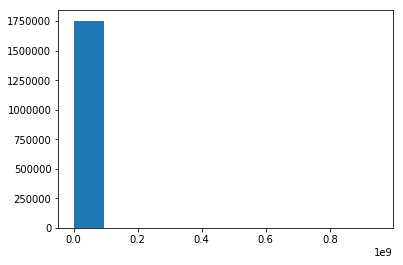

In [17]:
plt.hist(sell_df.price)
plt.show()

In [18]:
lower_bound = 0.1
upper_bound = 0.99
out = sell_df.price.quantile([lower_bound, upper_bound])
out

0.10      507310.0
0.99    23500000.0
Name: price, dtype: float64

In [19]:
true_index = (out.loc[lower_bound] <= sell_df.price.values)&\
(sell_df.price.values <= out.loc[upper_bound])

false_index = ~true_index

In [20]:
sell_df['price'] = sell_df.price[true_index]

In [21]:
sell_df['price'] = sell_df.price.fillna(0)
sell_df = sell_df[sell_df['price'] != 0]

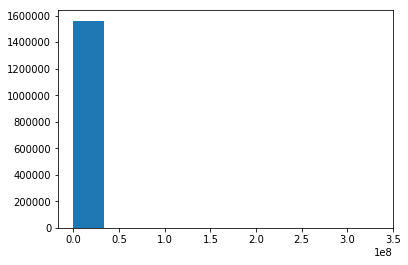

In [22]:
plt.hist(sell_df.surface_total_in_m2)
plt.show()

In [23]:
lower_bound = 0.1
upper_bound = 0.99
out = sell_df.surface_total_in_m2.quantile([lower_bound, upper_bound])
out

0.10      80.0
0.99    2200.0
Name: surface_total_in_m2, dtype: float64

In [24]:
true_index = (out.loc[lower_bound] <= sell_df.surface_total_in_m2.values)&\
(sell_df.surface_total_in_m2.values <= out.loc[upper_bound])

false_index = ~true_index

In [25]:
sell_df['surface_total_in_m2'] = sell_df.surface_total_in_m2[true_index]

In [26]:
sell_df['surface_total_in_m2'] = sell_df.surface_total_in_m2.fillna(0)
sell_df = sell_df[sell_df['surface_total_in_m2'] != 0]

In [27]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1391580 entries, 246 to 2762511
Data columns (total 12 columns):
id                     1391580 non-null object
operation              1391580 non-null object
created_on             1391580 non-null datetime64[ns]
property_type          1391580 non-null object
place_name             1391580 non-null object
state_name             1391580 non-null object
lat                    1391580 non-null float64
lon                    1391580 non-null float64
price                  1391580 non-null float64
currency               1391580 non-null object
price_aprox_usd        1391580 non-null float64
surface_total_in_m2    1391580 non-null float64
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 138.0+ MB


## Homologate State_Names

In [28]:
sell_df['state_name'] = sell_df.state_name.replace([ 'Estado de MÃ©xico', 'QuerÃ©taro','YucatÃ¡n','San Luis PotosÃ\xad',
                                         'Ciudad de MÃ©xico','Nuevo LeÃ³n', 'MichoacÃ¡n de Ocampo'],['Estado de México',
                                                                                                    'Querétaro',
                                                                                                    'Yucatán',
                                                                                                    'San Luis Potosí',
                                                                                                    'Ciudad de México',
                                                                                                    'Nuevo León',
                                                                                                    'Michoacan de Ocampo'])
sell_df['state_name'] = sell_df.state_name.replace(['Distrito Federal'],'Ciudad de México')

In [29]:
len(sell_df.state_name.unique())

32

# Regression & Corralation

In [30]:
sell_df.describe()

,lat,lon,price,price_aprox_usd,surface_total_in_m2
count,1.391580e+06,1.391580e+06,1.391580e+06,1.391580e+06,1.391580e+06
mean,2.080313e+01,-9.877579e+01,3.427474e+06,2.160610e+05,2.756705e+02
std,2.786982e+00,4.886864e+00,3.381032e+06,3.181362e+05,2.534003e+02
min,1.485189e+01,-1.171228e+02,5.077730e+05,2.340029e+04,8.000000e+01
25%,1.915615e+01,-1.004005e+02,1.401972e+06,7.928617e+04,1.260000e+02
50%,2.009684e+01,-9.925311e+01,2.250000e+06,1.268033e+05,1.980000e+02
75%,2.107516e+01,-9.822551e+01,3.966000e+06,2.300278e+05,3.200000e+02
max,4.259584e+01,1.031897e+02,2.350000e+07,2.200622e+07,2.200000e+03


The amount of data does no allow to see the tendency of the correlation between price and square meteres, that is why a clean data is needed for the analysis

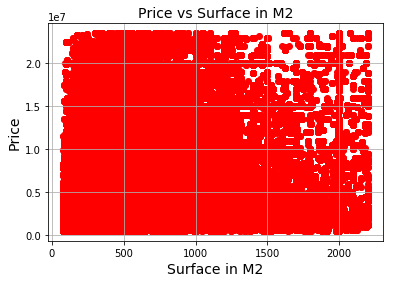

In [31]:
plt.scatter(sell_df['surface_total_in_m2'],sell_df['price'], color='red')
plt.title('Price vs Surface in M2', fontsize=14)
plt.xlabel('Surface in M2', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

In [32]:
dummy = pd.get_dummies(sell_df.state_name)

In [33]:
merge = pd.concat([sell_df,dummy], axis='columns')

In [34]:
merge.head()

,id,operation,created_on,property_type,place_name,state_name,lat,lon,price,currency,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
246,91bb3da684f234e18e0a2c98a115890b497f9a90,sell,2015-01-05,house,Oaxaca,Oaxaca,17.098608,-96.664839,4500000.0,MXN,...,0,0,0,0,0,0,0,0,0,0
249,d8241310f219cd4522159cbea340324af30eaba5,sell,2015-01-05,house,Morelos,Morelos,18.821062,-98.949371,1690000.0,MXN,...,0,0,0,0,0,0,0,0,0,0
250,8c6681d76c7448ee1e6525586e7b0f9a6b3592a1,sell,2015-01-05,house,Morelos,Morelos,18.873325,-98.974653,1450000.0,MXN,...,0,0,0,0,0,0,0,0,0,0
251,f9b6c4cb2d56473aff21f2b61ce5da24a5841184,sell,2015-01-05,house,Morelos,Morelos,18.805366,-98.919738,1630000.0,MXN,...,0,0,0,0,0,0,0,0,0,0
254,0a669470db1499fdd94969dc244ffd6362a4f6df,sell,2015-01-05,house,Ayala,Morelos,18.756647,-98.873201,620000.0,MXN,...,0,0,0,0,0,0,0,0,0,0


In [35]:
X = merge.drop(['id', 'created_on', 'operation', 'property_type', 'place_name',
       'state_name', 'lat', 'lon', 'price', 'currency', 'price_aprox_usd'], axis='columns') 
y = merge['price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [37]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 992766.916441178
Coefficients: 
 [    6880.93146253  -363617.59899025  -571338.84808826 -1554993.11042208
  -207560.68608432  -154642.66941677  -220379.20257085  2227469.31094876
  -942648.52512169  -583297.91830717  -906020.49854051  1071163.32606332
  -214626.59994175   558154.05143473  -433289.93275627  1370894.69231877
  -759578.01482511   156642.3446769   -216607.29935788  2748165.34087351
   393114.11675479   900056.04851865   555648.80067864   111532.00774303
    72643.95114119    30611.25639243  -545337.68525725   169082.61831199
  -562640.82344276  -718050.42878245  -142095.3832826   -903796.65654178
  -364655.98412445]


In [38]:
# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

C:\Users\w10\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                 2.218e+04
Date:                Mon, 01 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:06:20   Log-Likelihood:            -2.2608e+07
No. Observations:             1391580   AIC:                         4.522e+07
Df Residuals:                 1391547   BIC:                         4.522e+07
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [39]:
sell_df.to_csv("Results/sell_data_Mexico_since_2015.csv", index = False)